<a href="https://colab.research.google.com/github/alexistaylor3/CS536_FinalProject/blob/main/Cifar_Resnet_MOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Batch Size: 16
Beta 2: 0.99
"""
import torch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Subset

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    net.train()     
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(f"\tTest accuracy: {test_acc:.3f}\n\tTrain accuracy: {train_acc:.3f}")
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar = np.arange(len(training_loss_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=16
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#gotta take one of the classes from the cifar10 dataset and reduce it
trainarray = np.array(trainset.targets)

#separate the frogs
frog_class = np.where(np.array(trainarray) == 6)[0][:2000]

#remove frogs from the original train set
non_frog_class = np.where(np.array(trainarray) != 6)[0]

#now combine them again
reducedset = Subset(trainset, np.concatenate((frog_class, non_frog_class)))

#now printing the total size to make suer we removed some frogs
print(len(reducedset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(reducedset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=1)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)


net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

2.5.1+cu121
NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.5 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_35776\2299237312.py:166: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
47000
Files already downloaded and verified


Using cache found in C:\Users\Lexi/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.868, Ça coûte 11.221
[1,  2000] loss: 1.507, Ça coûte 24.542
[2,  1000] loss: 1.176, Ça coûte 11.106
[2,  2000] loss: 1.101, Ça coûte 24.766
[3,  1000] loss: 0.882, Ça coûte 10.757
[3,  2000] loss: 0.828, Ça coûte 25.400


KeyboardInterrupt: 

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_35776\3645972016.py:164: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
47000
Files already downloaded and verified


Using cache found in C:\Users\Lexi/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.589, Ça coûte 14.106
[2,  1000] loss: 1.043, Ça coûte 14.077
[3,  1000] loss: 0.760, Ça coûte 14.076
[4,  1000] loss: 0.592, Ça coûte 14.072
[5,  1000] loss: 0.459, Ça coûte 14.233
[6,  1000] loss: 0.344, Ça coûte 14.060
[7,  1000] loss: 0.254, Ça coûte 13.936
[8,  1000] loss: 0.183, Ça coûte 14.079
[9,  1000] loss: 0.139, Ça coûte 14.237
[10,  1000] loss: 0.104, Ça coûte 14.095
[11,  1000] loss: 0.081, Ça coûte 14.063
[12,  1000] loss: 0.068, Ça coûte 14.225
[13,  1000] loss: 0.056, Ça coûte 14.127
[14,  1000] loss: 0.049, Ça coûte 14.007
[15,  1000] loss: 0.043, Ça coûte 13.994
[16,  1000] loss: 0.038, Ça coûte 14.464
[17,  1000] loss: 0.036, Ça coûte 14.103
[18,  1000] loss: 0.030, Ça coûte 14.024
[19,  1000] loss: 0.027, Ça coûte 14.091
[20,  1000] loss: 0.026, Ça coûte 14.264
[21,  1000] loss: 0.023, Ça coûte 13.920
[22,  1000] loss: 0.022, Ça coûte 14.075
[23,  1000] loss: 0.021, Ça coûte 14.050
[24,  1000] loss: 0.019, Ça coûte 14.299
[25,  1000] loss: 0.017, 

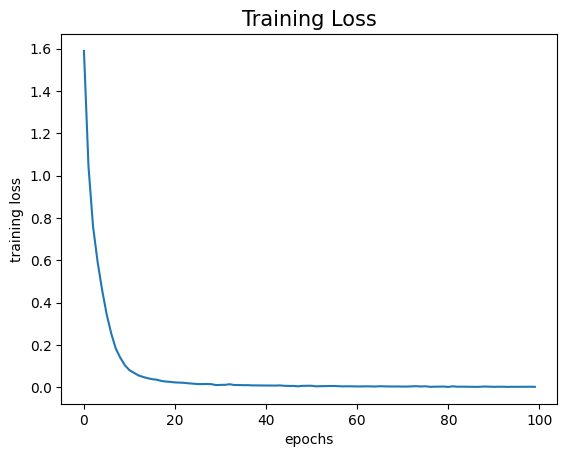

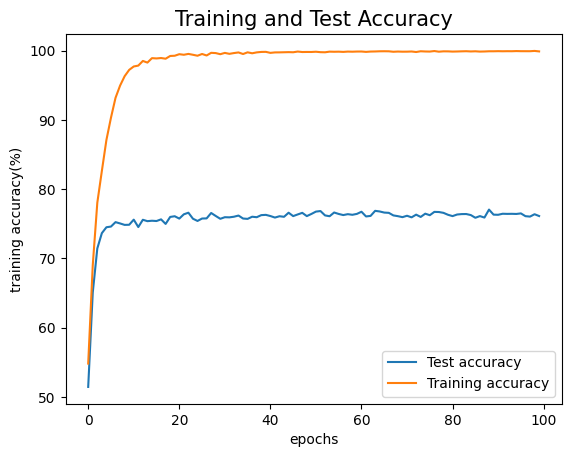

In [ ]:
"""
Batch Size: 32
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Subset

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    net.train()     
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                print(f"\tTest accuracy: {test_acc:.3f}\n\tTrain accuracy: {train_acc:.3f}")
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar = np.arange(len(training_loss_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#gotta take one of the classes from the cifar10 dataset and reduce it
trainarray = np.array(trainset.targets)

#separate the frogs
frog_class = np.where(np.array(trainarray) == 6)[0][:2000]

#remove frogs from the original train set
non_frog_class = np.where(np.array(trainarray) != 6)[0]

#now combine them again
reducedset = Subset(trainset, np.concatenate((frog_class, non_frog_class)))

#now printing the total size to make suer we removed some frogs
print(len(reducedset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(reducedset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)


net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_35776\363757542.py:164: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
47000
Files already downloaded and verified


Using cache found in C:\Users\Lexi/.cache\torch\hub\pytorch_vision_v0.6.0


[1,   100] loss: 1.849, Ça coûte 13.669
[2,   100] loss: 1.097, Ça coûte 13.177
[3,   100] loss: 0.801, Ça coûte 13.135
[4,   100] loss: 0.594, Ça coûte 13.271
[5,   100] loss: 0.420, Ça coûte 13.238
[6,   100] loss: 0.270, Ça coûte 13.612
[7,   100] loss: 0.172, Ça coûte 13.276
[8,   100] loss: 0.105, Ça coûte 13.309
[9,   100] loss: 0.068, Ça coûte 13.217
[10,   100] loss: 0.056, Ça coûte 13.429
[11,   100] loss: 0.047, Ça coûte 13.361
[12,   100] loss: 0.038, Ça coûte 13.413
[13,   100] loss: 0.033, Ça coûte 13.219
[14,   100] loss: 0.032, Ça coûte 13.369
[15,   100] loss: 0.022, Ça coûte 13.509
[16,   100] loss: 0.029, Ça coûte 13.419
[17,   100] loss: 0.021, Ça coûte 13.347
[18,   100] loss: 0.021, Ça coûte 13.292
[19,   100] loss: 0.021, Ça coûte 13.473
[20,   100] loss: 0.016, Ça coûte 13.405
[21,   100] loss: 0.013, Ça coûte 13.663
[22,   100] loss: 0.013, Ça coûte 13.609
[23,   100] loss: 0.011, Ça coûte 13.498
[24,   100] loss: 0.015, Ça coûte 13.353
[25,   100] loss: 0.009, 

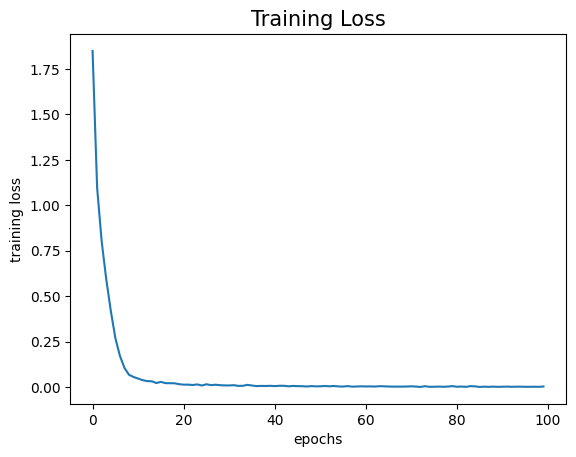

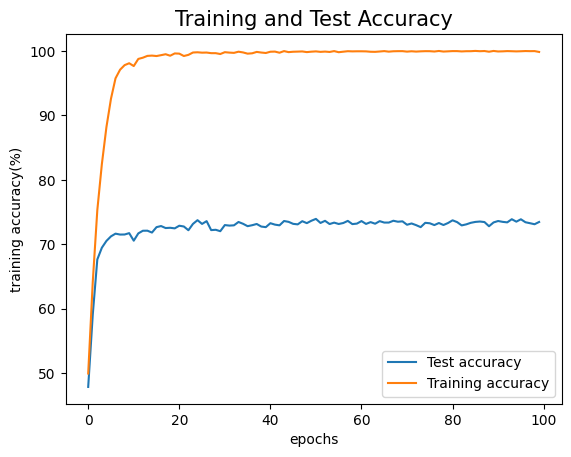

In [ ]:
"""
Batch Size: 256
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Subset

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    net.train()     
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=100
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(f"\tTest accuracy: {test_acc:.3f}\n\tTrain accuracy: {train_acc:.3f}")
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar = np.arange(len(training_loss_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=256
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#gotta take one of the classes from the cifar10 dataset and reduce it
trainarray = np.array(trainset.targets)

#separate the frogs
frog_class = np.where(np.array(trainarray) == 6)[0][:2000]

#remove frogs from the original train set
non_frog_class = np.where(np.array(trainarray) != 6)[0]

#now combine them again
reducedset = Subset(trainset, np.concatenate((frog_class, non_frog_class)))

#now printing the total size to make suer we removed some frogs
print(len(reducedset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(reducedset, batch_size=batchsize,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=4)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)


net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.4 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_35776\2739894225.py:164: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
47000
Files already downloaded and verified


Using cache found in C:\Users\Lexi/.cache\torch\hub\pytorch_vision_v0.6.0


[1,    50] loss: 2.136, Ça coûte 13.178
[2,    50] loss: 1.185, Ça coûte 13.084
[3,    50] loss: 0.834, Ça coûte 12.875
[4,    50] loss: 0.642, Ça coûte 13.367
[5,    50] loss: 0.459, Ça coûte 13.067
[6,    50] loss: 0.283, Ça coûte 13.156
[7,    50] loss: 0.166, Ça coûte 13.092
[8,    50] loss: 0.095, Ça coûte 13.294
[9,    50] loss: 0.059, Ça coûte 13.193
[10,    50] loss: 0.052, Ça coûte 13.022
[11,    50] loss: 0.034, Ça coûte 13.170
[12,    50] loss: 0.028, Ça coûte 13.097
[13,    50] loss: 0.030, Ça coûte 13.099
[14,    50] loss: 0.028, Ça coûte 13.333
[15,    50] loss: 0.022, Ça coûte 13.119
[16,    50] loss: 0.026, Ça coûte 13.124
[17,    50] loss: 0.017, Ça coûte 13.047
[18,    50] loss: 0.020, Ça coûte 13.183
[19,    50] loss: 0.009, Ça coûte 13.139
[20,    50] loss: 0.022, Ça coûte 13.175
[21,    50] loss: 0.012, Ça coûte 13.148
[22,    50] loss: 0.014, Ça coûte 13.228
[23,    50] loss: 0.020, Ça coûte 13.139
[24,    50] loss: 0.010, Ça coûte 13.380
[25,    50] loss: 0.015, 

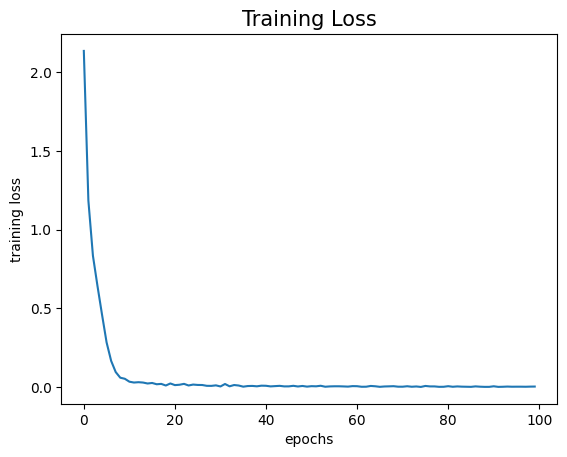

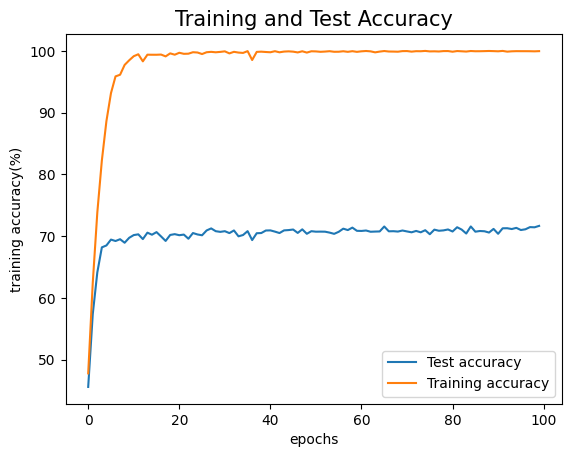

In [ ]:
"""
Batch Size: 512
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Subset

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    net.train()     
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=50
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(f"\tTest accuracy: {test_acc:.3f}\n\tTrain accuracy: {train_acc:.3f}")
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar = np.arange(len(training_loss_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=512
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#gotta take one of the classes from the cifar10 dataset and reduce it
trainarray = np.array(trainset.targets)

#separate the frogs
frog_class = np.where(np.array(trainarray) == 6)[0][:2000]

#remove frogs from the original train set
non_frog_class = np.where(np.array(trainarray) != 6)[0]

#now combine them again
reducedset = Subset(trainset, np.concatenate((frog_class, non_frog_class)))

#now printing the total size to make suer we removed some frogs
print(len(reducedset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(reducedset, batch_size=batchsize,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=4)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)


net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)